# Bootstrap Calibrations

In [62]:
%matplotlib inline

In [66]:
# imports
try:
    import seaborn as sns; sns.set(context="notebook",font_scale=2)
except:
    pass

from desispec import bootcalib as desiboot

from astropy.io import fits
from astropy.stats import sigma_clip

import numpy as np
from astropy.modeling import models, fitting
from xastropy.xutils import afits as xafits

## Find peaks

In [2]:
# Read flat
flat = fits.open('/Users/xavier/DESI/Wavelengths/pix-b0-00000001.fits')[0].data

In [3]:
reload(desiboot)
xpk, ypos, cut = desiboot.find_fiber_peaks(flat)#,debug=True)

Found 500 fibers
Found 20 bundles


In [5]:
# Check
plt.clf()
plt.figure(figsize=(16,7))
xplt = np.arange(cut.size)
plt.plot(xplt,cut, 'k-')
plt.plot(xpk, cut[xpk],'go')
plt.xlim(100,500)
plt.show()
plt.close()

## Trace the flat spectra

### Crude estimate (flux weighted centroid)

In [6]:
reload(desiboot)
xset, xerr = desiboot.trace_crude_init(flat,xpk[0:50],ypos)

### Polynomial fits (test)

In [7]:
yval = np.arange(4096)
ii=4
xval = xset[:,ii]
gdval = xerr[:,ii] < 999.
dfit0 = xafits.func_fit(yval[gdval],xval[gdval],'legendre',6)

In [8]:
fitv = xafits.func_val(yval,dfit0)

In [ ]:
# Fit
xdb.xplot(yval,fitv, xtwo=yval,ytwo=xset[:,ii],mtwo='+')

In [ ]:
# Residuals
xdb.xplot(yval[gdval],fitv[gdval]-xval[gdval], scatter=True)

### Polynomial fits (True)

In [9]:
reload(desiboot)
xfit, fdicts = desiboot.fit_traces(xset,xerr)#[:,0:5],xerr[:,0:5])

### QA

In [10]:
reload(desiboot)
desiboot.fiber_trace_qa(flat,xfit)

Writing fiber_trace_qa.pdf QA for fiber trace


## PSF

### Sigma for each fiber (initial guess)

In [13]:
reload(desiboot)
gauss = desiboot.fiber_gauss(flat,xfit,xerr)#,verbose=True)#,debug=True)

### Fit a 2nd Order Polynomial

In [14]:
fiber = np.arange(gauss.size)
gfdict,mask = xafits.iter_fit(fiber, gauss, 'polynomial', 2)

In [15]:
gfdict

{'coeff': array([  1.13884605e+00,  -6.21915177e-03,  -5.39514007e-05]),
 'func': 'polynomial',
 'order': 2,
 'xmax': 49,
 'xmin': 0}

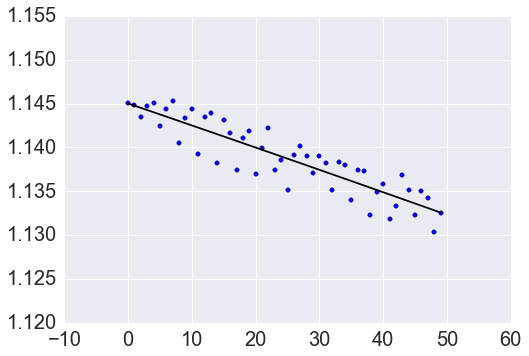

In [71]:
plt.clf()
plt.scatter(fiber,gauss)
plt.plot(fiber, xafits.func_val(fiber,gfdict),'k-')
#plt.xlim(100,500)
plt.show()
plt.close()

## Extract Arc (one fiber at a time)

### Load Image

In [17]:
arc = fits.open('/Users/xavier/DESI/Wavelengths/pix-b0-00000000.fits')[0].data

### Extract

In [39]:
reload(desiboot)
all_spec = desiboot.extract_sngfibers_gaussianpsf(arc,xfit,gauss)
all_spec.shape

0
10
20
30
40


(4096, 50)

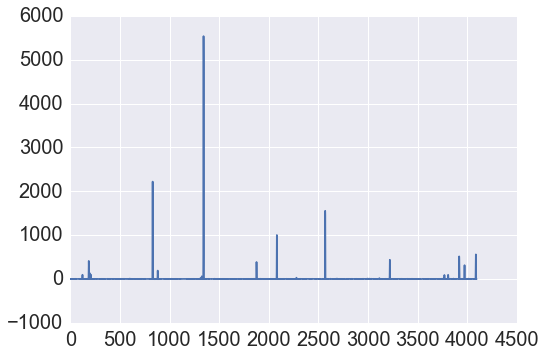

In [70]:
xdb.xplot(np.arange(all_spec[:,0].size), all_spec[:,0])#, sv_aspec[1], sv_aspec[2])

## Wavelength info

In [41]:
# Dispersion
import desimodel.io

In [42]:
desi_psf = desimodel.io.load_psf('b')

In [43]:
desi_psf.wdisp(0,4500.) # fiber, wavelength

0.623491140761951

In [44]:
wave0 = desi_psf.wavelength(0,np.arange(desi_psf.npix_y))

In [45]:
np.max(wave0)

5948.6835574399602

In [46]:
med_bdisp = np.median(desi_psf.wdisp(0,wave0))
med_bdisp

0.63191076246357203

In [47]:
np.median(np.abs(wave0-np.roll(wave0,1)))

0.5920365191327619

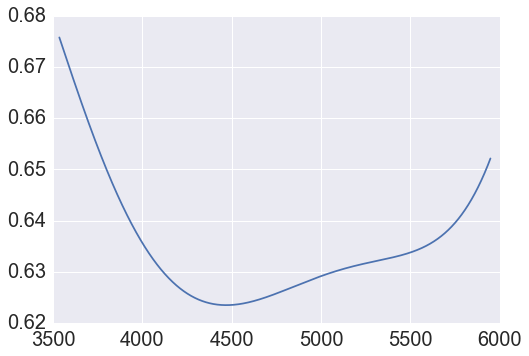

In [68]:
xdb.xplot(wave0,desi_psf.wdisp(0,wave0))

In [49]:
desi_psf.npix_x, desi_psf.npix_y

(4096, 4096)

In [50]:
poly_fit = xafits.func_fit(wave0,np.arange(desi_psf.npix_y), 'polynomial',2,xmin=0.,xmax=1.)
poly_fit

{'coeff': array([ -5.05608278e+03,   6.38522295e-01,   1.09530252e-05]),
 'func': 'polynomial',
 'order': 2,
 'xmax': 1.0,
 'xmin': 0.0}

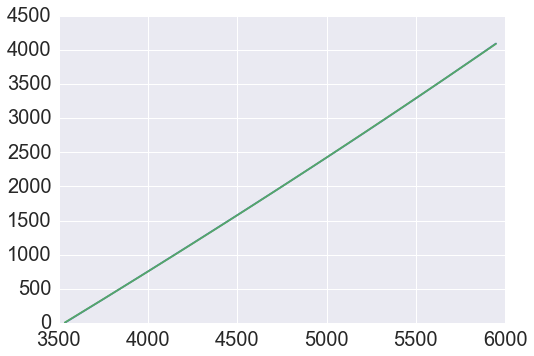

In [69]:
xdb.xplot(wave0, np.arange(desi_psf.npix_y),xafits.func_val(wave0,poly_fit))

## Find Lines

In [79]:
reload(desiboot)
spec = all_spec[:,0]
xpk = desiboot.find_arc_lines(spec)

In [100]:
len(xpk)

19

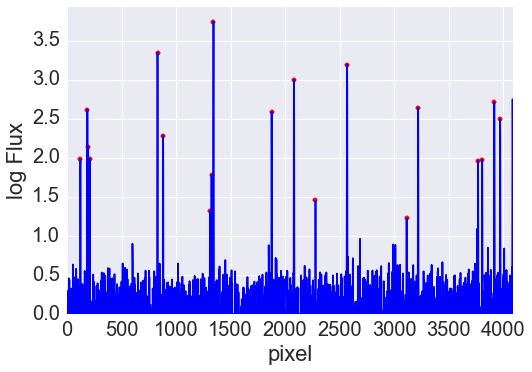

In [81]:
plt.clf()
yspec = np.log10(np.maximum(spec,1))
xplt = np.arange(spec.size)
plt.plot(xplt,yspec,'b-')
plt.scatter(xpk,yspec[np.round(xpk).astype(int)],color='red')
plt.ylim(0.,np.max(yspec)*1.05)
plt.xlim(0,spec.size)
plt.xlabel('pixel')
plt.ylabel('log Flux')
plt.show()
plt.close()

## Identify Arc Lines

In [72]:
sys.path.append(os.path.abspath(os.getenv('PYPIT')+"/src"))
import ararclines as pypit_alines
import ararc as pypit_arc

[WARNING] :: ds9 module not installed


### Load line list and parameters

In [73]:
arcparam = dict(llist=None, 
    disp=0.592,           # Ang (unbinned)
    b1=0.,               # Pixel fit term (binning independent)
    b2=0., #1.09530252e-05/arc.shape[0],               # Pixel fit term
    wvmnx=[3500.,6000.],# Pixel fit term
    disp_toler=0.1,      # 10% tolerance
    match_toler=5.,      # Matcing tolerance (pixels)
    func='legendre',     # Function for fitting
    n_first=1,           # Order of polynomial for first fit
    n_final=4,           # Order of polynomial for final fit
    nsig_rej=2.,         # Number of sigma for rejection
    nsig_rej_final=3.0,  # Number of sigma for rejection (final fit)
    Nstrong=15)  
arcparam['b1']= 1./arcparam['disp']/arc.shape[0] 
aparm = arcparam
aparm

{'Nstrong': 15,
 'b1': 0.0004123997043918919,
 'b2': 0.0,
 'disp': 0.592,
 'disp_toler': 0.1,
 'func': 'legendre',
 'llist': None,
 'match_toler': 5.0,
 'n_final': 4,
 'n_first': 1,
 'nsig_rej': 2.0,
 'nsig_rej_final': 3.0,
 'wvmnx': [3500.0, 6000.0]}

In [74]:
reload(pypit_alines)
#llist = pypit_alines.load_arcline_list(None,None,['CdI','ArI','NeI','HgI'],wvmnx=aparm['wvmnx'])
llist = pypit_alines.load_arcline_list(None,None,['CdI','ArI','HgI','NeI'],wvmnx=aparm['wvmnx'])

[INFO]    :: Rejecting select CdI lines
[INFO]    :: Rejecting select ArI lines
[INFO]    :: Rejecting select HgI lines
[INFO]    :: Rejecting select NeI lines
[INFO]    :: Cutting down line list by wvmnx: 3500,6000


In [75]:
arcparam['llist'] = llist

### Auto-ID

In [ ]:
tampl = arc_spec[xpk]
tcent = xpk
# Need to improve centroid to sub-pixel (flux-weight)

In [ ]:
# Generate dpix pairs
nlist = len(llist)
dpix_list = np.zeros((nlist,nlist))
for kk,row in enumerate(llist):
    dpix_list[kk,:] = arc.shape[0]*(aparm['b1']*(np.array(row['wave'] - llist['wave'])) + aparm['b2']*np.array(row['wave']**2 - llist['wave']**2) )

In [ ]:
dpix_list[8,:]

In [ ]:
dpix_list[13,:]

In [ ]:
# Pixel pairs for the strongest N lines
srt = np.argsort(tampl)
idx_str = srt[-aparm['Nstrong']:]
idx_str.sort()
dpix_obs = np.zeros((aparm['Nstrong'],aparm['Nstrong']))
for kk,idx in enumerate(idx_str):
    dpix_obs[kk,:] = np.array(tcent[idx] - tcent[idx_str]) # pixels

In [ ]:
dpix_obs[8,:]

In [ ]:
# Match up (ugly loops)
ids = np.zeros(aparm['Nstrong'])
ids2 = np.zeros(aparm['Nstrong'])
ions = np.array(['12345']*aparm['Nstrong'])
for kk in range(aparm['Nstrong']):
    med_off = np.zeros(nlist)
    mean_off = np.zeros(nlist)
    for ss in range(nlist):
        dpix = dpix_list[ss]
        min_off = []
        for jj in range(aparm['Nstrong']):
            min_off.append(np.min(np.abs(dpix_obs[kk,jj]-dpix)))
        min_off.sort()
        mean_off[ss] = np.mean(min_off[:-1])
        med_off[ss] = np.median(min_off)
    #xdb.set_trace()
#        if (kk == 1) & ((ss == 13) or (ss==8)):
#            xdb.set_trace()
    # Set by minimum
    idm = np.argmin(med_off)
    idm2 = np.argmin(mean_off)
    print(kk,mean_off[idm2])
    ids2[kk] = llist['wave'][idm]
    ids[kk] = llist['wave'][idm2]
    ions[kk] = llist['Ion'][idm]

In [ ]:
xdb.xpcol(ids,ids2)

In [ ]:
# Calculate disp of the strong lines
disp_str = np.zeros(aparm['Nstrong'])
for kk in range(aparm['Nstrong']):
    disp_str[kk] = np.median( (ids[kk]-ids)/
        (tcent[idx_str[kk]]-tcent[idx_str]) )
# Consider calculating the RMS with clipping
gd_str = np.where( np.abs(disp_str-aparm['disp'])/aparm['disp'] < aparm['disp_toler'])[0]
print('Found {:d} lines within the disperesion threshold'.format(len(gd_str)))
if len(gd_str) < 5:
    raise ValueError('Insufficient lines to auto-fit.')

In [ ]:
xdb.xpcol(np.arange(len(ids)),ids,disp_str)

In [ ]:
#Plot
plt.clf()
xplt = np.arange(arc_spec.size)
plt.plot(xplt,arc_spec)
# Label
for gds in gd_str:
    plt.text(tcent[idx_str[gds]], tampl[idx_str[gds]], '{:s} {:g}'.format(ions[gds],ids[gds]), rotation=90., va='bottom')
plt.show()

In [ ]:
# Fit
#Plot
plt.clf()
plt.scatter(ids[gd_str],tcent[idx_str[gd_str]],color='blue')
plt.plot(wave0,np.arange(wave0.size),'g-')                
plt.show()

In [ ]:
# Residual
resid = tcent[idx_str[gd_str]] - xafits.func_val(ids[gd_str], poly_fit)
plt.clf()
plt.scatter(ids[gd_str],resid,color='blue')
plt.show()

In [ ]:
ids[gd_str]

### Triplets (this was a bit off track)

In [ ]:
llist.sort('wave')
nline = len(llist)

In [ ]:
llist['wave']

In [ ]:
# Generate
#3610, 3650., 3654
line_triplets = []
for kk in range(1,nline-1):
    #print(kk)
    # Setup array
    triplets = np.zeros( (3,kk,nline-kk-1))
    wv2 = llist['wave'][kk]
    # Loop on LHS
    for jj in range(kk):
        wv1 = llist['wave'][jj]
        wvmm = llist['wave'][kk+1:]
#        if kk == 2:
#            xdb.set_trace()
        triplets[0,jj,:] = (wv2-wv1)/(wvmm-wv1)
        triplets[1,jj,:] = (wv2-wv1)/(wvmm-wv2)
        triplets[2,jj,:] = (wvmm-wv2)/(wvmm-wv1)
#        if kk == 34: 
#            if np.sum(np.abs(triplets[1,jj,:]-8)<1e-5)>0:
#                xdb.set_trace()
        #triplets[3,jj,:] = wvmm-wv1 # dlamb
    # Enforce 0-1 range
    #if kk == 1:
    #    xdb.set_trace()
    #inverse = triplets > 1.
    #triplets[inverse] = 1./triplets[inverse]
    # Reshape
#    if kk == 34:
#        xdb.set_trace()
    triplets = np.reshape(triplets,(3,triplets.shape[1]*triplets.shape[2]))
    # Sort
    #triplets = np.sort(triplets, axis=0)
    # Append
    #xdb.set_trace()
    line_triplets.append(triplets)       

#### Test

In [ ]:
tcent[0:3]

In [ ]:
ii = 1
triplet_obs = [ float(tcent[ii]-tcent[ii-1])/float(tcent[ii+1]-tcent[ii-1]),
               float(tcent[ii]-tcent[ii-1])/float(tcent[ii+1]-tcent[ii]),
               float(tcent[ii+1]-tcent[ii])/float(tcent[ii+1]-tcent[ii-1])]
print(tcent[ii-1:ii+2])
triplet_o = np.array(triplet_obs)
# inverse
#inverse = triplet_o > 1.
#triplet_o[inverse] = 1./triplet_o[inverse]
#
#triplet_obs = np.sort(triplet_o)
triplet_o

In [ ]:
# Loop on lines
all_diff = []
for kk,ltrip in enumerate(line_triplets):
    diff = np.abs(ltrip.T - triplet_o)
    min_diff = np.min(np.sum(diff,axis=1))
    imin = np.argmin(np.sum(diff,axis=1))
    if min_diff < 0.03:
        pass
        #dlamb = 1./(ltrip[3,imin]*(tcent[ii+1]-tcent[ii-1]))
        #print('wave={:g}, min={:g}, dlamb={:g}'.format(llist['wave'][kk+1],min_diff))#,dlamb))
    #all_diff.append(ltrip)
    #xdb.set_trace()
    #print(kk,min_diff)
    #if kk == 33:
    #    xdb.set_trace()

In [ ]:
ltrip = line_triplets[0]

In [ ]:
diff = np.abs(ltrip[:,0:3] - triplet_o)

In [ ]:
np.min(np.sum(diff,axis=1))

In [ ]:
xdb.xplot(arc_spec)

## A New Solution

### Find all $\Delta \lambda$ pairs in the line list

In [ ]:
llist.sort('wave')
nline = len(llist)
nline

In [ ]:
npair = np.sum(np.arange(nline))
npair

In [ ]:
Dlamb = np.zeros((3,npair)) # index, index, dlamb
count = 0
for kk in range(nline-1):
    jidx = np.arange(kk+1,nline)
    cidx = np.arange(jidx.size)
    dl = llist['wave'][jidx] - llist['wave'][kk]
    # Fill
    Dlamb[0,count+cidx] = kk
    Dlamb[1,count+cidx] = jidx
    Dlamb[2,count+cidx] = dl
    count += cidx.size

### Using a $\delta\lambda$ guess, find all matches within tolerance

In [86]:
toler = 0.2

In [87]:
dlamb = (wave0[-1]-wave0[0])/wave0.size
dlamb

0.58944396087634243

In [ ]:
#
Dobs = (tcent[-1]-tcent[0])*dlamb
Dobs

In [ ]:
#Normalized pattern of tcent
xtcent = (tcent[1:-1]-tcent[0])/float(tcent[-1]-tcent[0])
xtcent

In [ ]:
# All matches within tolerance
gdp = np.where(np.abs(Dobs-Dlamb[2,:])/Dobs < toler)[0]
gdp.size

In [ ]:
#
mtch_wv = np.zeros( (tcent.size, gdp.size))
mtch_idx = np.zeros( (tcent.size, gdp.size),dtype=int)

In [ ]:
# Loop on gdp
metric = np.zeros(gdp.size)
for qq,igd in enumerate(gdp):
    # Endpoints
    i0,i1 = Dlamb[0,igd], Dlamb[1,igd]
    mtch_wv[0,qq] = llist['wave'][i0]
    mtch_wv[-1,qq] = llist['wave'][i1]
    mtch_idx[0,qq] = i0
    mtch_idx[-1,qq] = i1
    # Normalized pattern of lines
    xline = (llist['wave'][i0+1:i1]-llist['wave'][i0])/(llist['wave'][i1]-llist['wave'][i0])
    # Minimize tcent
    for jj,xt in enumerate(xtcent):
        diff = np.abs(xt-xline)
        imin = np.argmin(diff)
        # Increment and save
        metric[qq] += diff[imin]
        mtch_wv[jj+1,qq] = llist['wave'][i0+imin+1]
        mtch_idx[jj+1,qq] = i0+imin+1

In [ ]:
xdb.xhist(metric)

In [ ]:
best_met = np.argmin(metric)
best_met

In [ ]:
mtch_wv[:,best_met]

In [ ]:
mtch_idx[:,best_met]

In [ ]:
srt = np.argsort(metric)

In [ ]:
srt[0:5]

In [ ]:
gdwv = np.median(mtch_wv[:,srt[0:5]],axis=1)
gdwv

In [ ]:
gdidx = np.median(mtch_idx[:,srt[0:5]],axis=1)
gdidx

In [ ]:
#Plot with labels
plt.clf()
xplt = np.arange(arc_spec.size)
plt.plot(xplt,arc_spec)
# Label
for ii in range(tcent.size):
    plt.text(tcent[ii], tampl[ii], '{:g}'.format(gdwv[ii]), rotation=90., va='bottom')
plt.show()

In [ ]:
xdb.xplot(wave0,arc_spec)

### Quint method

In [ ]:
iq=14 # Marked line

In [ ]:
quint = tcent[iq+np.arange(5)-2]
quint

#### How far to loop from guess??

In [ ]:
guesses = np.arange(gdidx[iq-3],gdidx[iq+1]+1)
qmetric = np.ones(guesses.size) * 999.
#
Dlm1 = dlamb*(tcent[iq]-tcent[iq-1])
Dlp1 = dlamb*(tcent[iq+1]-tcent[iq])
#
x1 = (tcent[iq-1]-tcent[iq-2])/float(tcent[iq]-tcent[iq-2])
x2 = (tcent[iq]-tcent[iq-1])/float(tcent[iq+1]-tcent[iq-1])
x3 = (tcent[iq+1]-tcent[iq])/float(tcent[iq+2]-tcent[iq])

for ss,icen in enumerate(guesses):
    wcen = llist['wave'][icen]
    print('wcen = {:g}'.format(wcen))
    # Find possible i-1
    Dlm = wcen-llist['wave'][0:icen]
    gdm = np.where(np.abs(Dlm-Dlm1)/Dlm1<toler)[0]
    # Find possible i+1
    Dlp = llist['wave'][icen+1:]-wcen
    gdp = np.where(np.abs(Dlp-Dlp1)/Dlp1<toler)[0]
    #
    nposs = len(gdm)*len(gdp)
    if (nposs == 0):
        continue
    # Ugly loops
    sub_metric = np.zeros(nposs)
    count=0
    for igdm in gdm:
        # 012
        lx1 = (llist['wave'][igdm]-llist['wave'][0:igdm])/(wcen-llist['wave'][0:igdm])
        sub_metric[count+np.arange(gdp.size)] += np.min(np.abs(lx1-x1))
        for igdp in gdp:
            # 123
            sub_metric[count] += np.abs(x2-(wcen-llist['wave'][igdm])/(llist['wave'][icen+1+igdp]-llist['wave'][igdm]))
            count += 1
    count=0
    for igdp in gdp:
        # 234
        lx3 = (llist['wave'][icen+1+igdp]-wcen)/(llist['wave'][icen+2+igdp:]-wcen)
        sub_metric[count*gdm.size+np.arange(gdm.size)] += np.min(np.abs(lx3-x3))
        #xdb.set_trace()
    qmetric[ss] = np.min(sub_metric)


In [ ]:
xdb.xpcol(llist['wave'][guesses.astype(int)], qmetric)

In [ ]:
xdb.xplot(arc_spec)

## Fitting approach

In [ ]:
from astropy.modeling import models, fitting
import copy

In [ ]:
# For fitting
fitter = fitting.LevMarLSQFitter()

In [ ]:
# Setup model
poly = models.Polynomial1D(2)
poly

In [ ]:
# Set bounds
poly.c1.bounds = (6.38522295e-01*0.8, 6.38522295e-01*1.2)

In [ ]:
xdb.xplot(wave0,arc_spec)

### Init

In [94]:
camera = 'b'

In [89]:
toler = 0.2

### Grab lines

In [104]:
reload(desiboot)
dlamb, wmark, gd_lines = desiboot.load_gdarc_lines(camera)
dlamb, wmark, gd_lines

(0.589,
 4358.34,
 array([ 3610.51 ,  3650.157,  4046.57 ,  4077.84 ,  4358.34 ,  4678.15 ,
         4799.91 ,  5085.822,  5460.75 ,  5769.598,  5881.895,  5944.834]))

### Match a set of 5 gd_lines to detected lines

In [141]:
reload(desiboot)
id_dict = desiboot.id_arc_lines(xpk,gd_lines,dlamb,wmark)

In [142]:
id_dict

{u'first_id_idx': [4, 5, 8, 9, 10],
 u'first_id_pix': array([  829.72229862,   880.90758168,  1343.18202243,  1876.81683412,
         2082.08519489]),
 u'first_id_wave': array([ 4046.57,  4077.84,  4358.34,  4678.15,  4799.91]),
 u'fit': {'coeff': array([ -5.20987817e+03,   6.74857691e-01,   8.83540824e-06]),
  'func': u'polynomial',
  'order': 2,
  'xmax': 1.0,
  'xmin': 0.0},
 'guess': 8,
 u'icen': 4,
 'im1': 5,
 'im2': 4,
 'ip1': 9,
 'ip2': 10,
 'rms': 0.052928404679943641,
 u'wmark': 4358.34}

/Users/xavier/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


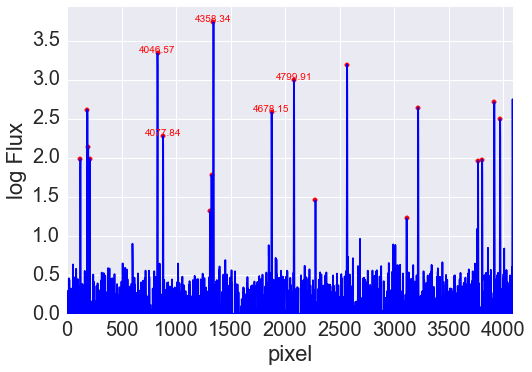

In [136]:
plt.clf()
yspec = np.log10(np.maximum(spec,1))
xplt = np.arange(spec.size)
plt.plot(xplt,yspec,'b-')
plt.scatter(xpk,yspec[np.round(xpk).astype(int)],color='red')
# Guesses
for jj,pixpk in enumerate(id_dict['first_id_pix']):
    plt.text(pixpk, yspec[np.round(pixpk)], '{:g}'.format(id_dict['first_id_wave'][jj]),
         ha='center',color='red')
#
plt.ylim(0.,np.max(yspec)*1.05)
plt.xlim(0,spec.size)
plt.xlabel('pixel')
plt.ylabel('log Flux')
plt.show()
plt.close()

### Idenfity additional selected lines

In [158]:
reload(desiboot)
desiboot.add_arc_lines(id_dict, xpk, gd_lines)

rms = 0.211782


In [159]:
id_dict

{u'first_fit': {'coeff': array([ -5.20987817e+03,   6.74857691e-01,   8.83540824e-06]),
  'func': u'polynomial',
  'order': 2,
  'xmax': 1.0,
  'xmin': 0.0},
 u'first_id_idx': [4, 5, 8, 9, 10],
 u'first_id_pix': array([  829.72229862,   880.90758168,  1343.18202243,  1876.81683412,
         2082.08519489]),
 u'first_id_wave': array([ 4046.57,  4077.84,  4358.34,  4678.15,  4799.91]),
 u'fit': {'coeff': array([ -5.72214827e+03,   8.54716127e-01,  -1.21185661e-05,
           8.09982769e-10]),
  'func': u'polynomial',
  'order': 3,
  'xmax': 1.0,
  'xmin': 0.0},
 'guess': 8,
 u'icen': 4,
 u'id_idx': [0, 1, 4, 5, 8, 9, 10, 12, 14, 15],
 u'id_pix': [122.21966759781186,
  186.00190784674282,
  829.72229862287475,
  880.90758167860508,
  1343.182022432715,
  1876.8168341159892,
  2082.0851948899963,
  2569.2857170092207,
  3221.1382103514738,
  3770.7604591350064],
 u'id_wave': [3610.5100000000002,
  3650.1570000000002,
  4046.5700000000002,
  4077.8400000000001,
  4358.3400000000001,
  4678.

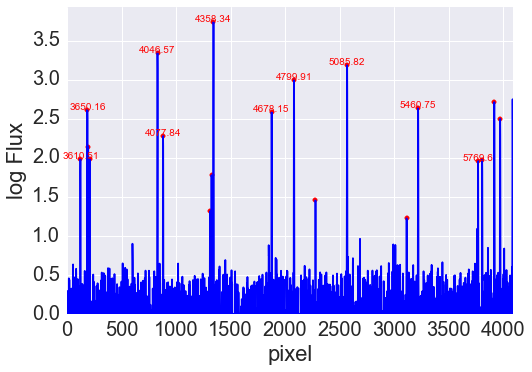

In [160]:
# IDs
plt.clf()
yspec = np.log10(np.maximum(spec,1))
xplt = np.arange(spec.size)
plt.plot(xplt,yspec,'b-')
plt.scatter(xpk,yspec[np.round(xpk).astype(int)],color='red')
# Guesses
for jj,pixpk in enumerate(id_dict['id_pix']):
    plt.text(pixpk, yspec[int(np.round(pixpk))], '{:g}'.format(id_dict['id_wave'][jj]),
         ha='center',color='red')
#
plt.ylim(0.,np.max(yspec)*1.05)
plt.xlim(0,spec.size)
plt.xlabel('pixel')
plt.ylabel('log Flux')
plt.show()
plt.close()

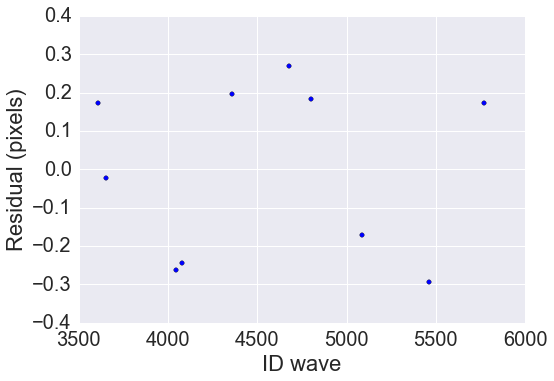

In [162]:
# Residuals
plt.clf()
# Fit
yfit = xafits.func_val(np.array(id_dict['id_wave']),id_dict['fit'])
# IDs
plt.scatter(id_dict['id_wave'], np.array(id_dict['id_pix'])-yfit)
#
plt.xlabel('ID wave')
plt.ylabel('Residual (pixels)')
plt.show()
plt.close()

### Identify as many others as possible

In [164]:
# Forward fit
pixwv_fit = xafits.func_fit(np.array(id_dict['id_pix']),np.array(id_dict['id_wave']),'polynomial',3,xmin=0.,xmax=1.)

In [167]:
# Loop on non-IDs
wv_toler = 3.*dlamb # Ang
for ii,ixpk in enumerate(xpk):
    if ii in id_dict['id_idx']:
        continue
    # Predict wavelength
    wv_pk = xafits.func_val(ixpk,pixwv_fit)
    # Search for a match
    mt = np.where(np.abs(llist['wave']-wv_pk)<wv_toler)[0]
    if len(mt) == 1:
        print('Matched {:g} to {:g}'.format(ixpk,llist['wave'][mt[0]])) 
        id_dict['id_idx'].append(ii)
        id_dict['id_pix'].append(ixpk)
        id_dict['id_wave'].append(llist['wave'][mt[0]])
# Sort
id_dict['id_idx'].sort()
id_dict['id_pix'].sort()
id_dict['id_wave'].sort()

In [168]:
id_dict

{u'first_fit': {'coeff': array([ -5.20987817e+03,   6.74857691e-01,   8.83540824e-06]),
  'func': u'polynomial',
  'order': 2,
  'xmax': 1.0,
  'xmin': 0.0},
 u'first_id_idx': [4, 5, 8, 9, 10],
 u'first_id_pix': array([  829.72229862,   880.90758168,  1343.18202243,  1876.81683412,
         2082.08519489]),
 u'first_id_wave': array([ 4046.57,  4077.84,  4358.34,  4678.15,  4799.91]),
 u'fit': {'coeff': array([ -5.72214827e+03,   8.54716127e-01,  -1.21185661e-05,
           8.09982769e-10]),
  'func': u'polynomial',
  'order': 3,
  'xmax': 1.0,
  'xmin': 0.0},
 'guess': 8,
 u'icen': 4,
 u'id_idx': [0, 1, 2, 3, 4, 5, 8, 9, 10, 12, 14, 15, 16, 17, 18],
 u'id_pix': [122.21966759781186,
  186.00190784674282,
  193.63640931521709,
  207.15572236253539,
  829.72229862287475,
  880.90758167860508,
  1343.182022432715,
  1876.8168341159892,
  2082.0851948899963,
  2569.2857170092207,
  3221.1382103514738,
  3770.7604591350064,
  3808.568793226988,
  3920.2128968291004,
  3973.6305308845363],
 u

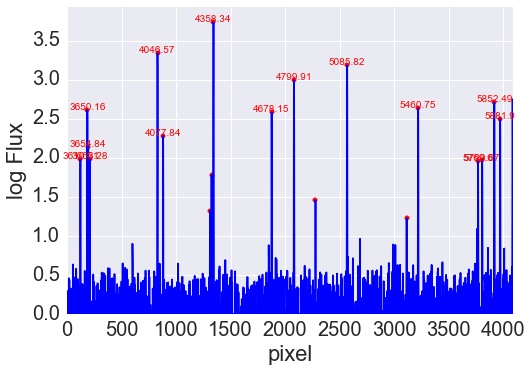

In [169]:
# IDs
plt.clf()
yspec = np.log10(np.maximum(spec,1))
xplt = np.arange(spec.size)
plt.plot(xplt,yspec,'b-')
plt.scatter(xpk,yspec[np.round(xpk).astype(int)],color='red')
# Guesses
for jj,pixpk in enumerate(id_dict['id_pix']):
    plt.text(pixpk, yspec[int(np.round(pixpk))], '{:g}'.format(id_dict['id_wave'][jj]),
         ha='center',color='red')
#
plt.ylim(0.,np.max(yspec)*1.05)
plt.xlim(0,spec.size)
plt.xlabel('pixel')
plt.ylabel('log Flux')
plt.show()
plt.close()

In [170]:
# Fit with rejection
final_fit,mask = xafits.iter_fit(np.array(id_dict['id_wave']),np.array(id_dict['id_pix']),'polynomial',3,xmin=0.,xmax=1.)

In [171]:
# Plot residuals

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])